In [1]:
# This notebook illustrates handling the August 2024 Demo of the 12mo Evaluation Scenario 1

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman import FunmanWorkRequest, EncodingSchedule 
import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
import pandas as pd
import logging
import matplotlib.pyplot as plt



RESOURCES = "../../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-08", "12_month_scenario_1", "q1a_ii")
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "eval_scenario1_base_request.json")

models = {
    "original_stratified":  os.path.join(
    EXAMPLE_DIR, "eval_scenario1_1_ii_3.json"),
    "destratified_SEI": os.path.join(
    EXAMPLE_DIR, "eval_scenario1_1_ii_3_destratified_all.json"
),
    "destratified_SE": os.path.join(
    EXAMPLE_DIR, "eval_scenario1_1_ii_3_destratified_SE.json"
)
}

states = {
    "original_stratified":  ["S_compliant", "S_noncompliant", "I_compliant", "I_noncompliant", "E_compliant", "E_noncompliant","R", "H", "D"],
    "destratified_SEI": ["S_lb", "S_ub", "I_lb", "I_ub", "E_lb", "E_ub","R_lb", "R_ub","H_lb", "H_ub", "D_lb","D_ub"],
    "destratified_SE": ["S_lb", "S_ub", "I_compliant_lb", "I_compliant_ub", "I_noncompliant_lb", "I_noncompliant_ub","E_lb", "E_ub","R_lb", "R_ub","H_lb", "H_ub", "D_lb","D_ub"]
}

basevar_map = [
    ['S_compliant','S_noncompliant', 'S_lb', 'S_ub'], 
    ['I_compliant','I_noncompliant','I_lb','I_ub','I_compliant_lb', 'I_noncompliant_ub', 'I_compliant_ub', 'I_noncompliant_lb'],
    ['E_compliant','E_noncompliant','E_lb',   'E_ub'],
    ['R','R_lb', 'R_ub'],
    ['H','H_lb', 'H_ub'],
    ['D','D_lb', 'D_ub']
    ]

request_params = {}
request_results = {}

# Cycle styles for lines
plt.rcParams['axes.prop_cycle'] = ("cycler('color', 'rgb') +"
                                   "cycler('lw', [1, 2, 3])")

# %load_ext autoreload
# %autoreload 2

In [2]:
# Constants for the scenario

MAX_TIME=5
STEP_SIZE=1
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))

In [3]:
# Helper functions to setup FUNMAN for different steps of the scenario

from email.mime import base


def get_request():
    with open(REQUEST_PATH, "r") as request:
        funman_request = FunmanWorkRequest.model_validate(json.load(request))
        return funman_request

def set_timepoints(funman_request, timepoints):
    funman_request.structure_parameters[0].schedules = [EncodingSchedule(timepoints=timepoints)]

def unset_all_labels(funman_request):
    for p in funman_request.parameters:
        p.label = "any"
    
def set_config_options(funman_request, debug=False, dreal_precision=1e-1):
    # Overrides for configuration
    #
    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    # funman_request.config.use_compartmental_constraints=False
    if debug:
        funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.01
    funman_request.config.dreal_precision = dreal_precision
    funman_request.config.verbosity = logging.INFO
    # funman_request.config.dreal_log_level = "debug"
    # funman_request.config.dreal_prefer_parameters = ["beta","NPI_mult","r_Sv","r_EI","r_IH_u","r_IH_v","r_HR","r_HD","r_IR_u","r_IR_v"]

def get_synthesized_vars(funman_request):
    return [p.name for p in funman_request.parameters if p.label == "all"]

def run(funman_request, plot=False, model=models['original_stratified']):
    to_synthesize = get_synthesized_vars(funman_request)
    results =  Runner().run(
        model,
        funman_request,
        description="SIERHD Eval 12mo Scenario 1 q1",
        case_out_dir=SAVED_RESULTS_DIR,
        dump_plot=plot,
        print_last_time=True,
        parameters_to_plot=to_synthesize
    )
    return results

def setup_common(funman_request, synthesize=False, debug=False, dreal_precision=1e-1):
    set_timepoints(funman_request, timepoints)
    if not synthesize:
        unset_all_labels(funman_request)
    set_config_options(funman_request, debug=debug, dreal_precision=dreal_precision)
    

def set_compartment_bounds(funman_request, model, upper_bound=9830000.0, error=0.01):
    # Add bounds to compartments
    for var in states[model]:
        funman_request.constraints.append(StateVariableConstraint(name=f"{var}_bounds", variable=var, interval=Interval(lb=0, ub=upper_bound, closed_upper_bound=True),soft=False))

    # Add sum of compartments
    funman_request.constraints.append(LinearConstraint(name=f"compartment_bounds", variables=states[model], additive_bounds=Interval(lb=upper_bound-error, ub=upper_bound+error, closed_upper_bound=False), soft=True))

def relax_parameter_bounds(funman_request, factor = 0.1):
    # Relax parameter bounds
    parameters = funman_request.parameters
    for p in parameters:
        interval = p.interval
        width = float(interval.width())
        interval.lb = interval.lb - (factor/2 * width)
        interval.ub = interval.ub + (factor/2 * width)

def plot_last_point(results, states):
    pts = results.parameter_space.points() 
    print(f"{len(pts)} points")

    if len(pts) > 0:
        # Get a plot for last point
        df = results.dataframe(points=pts[-1:])
        # pd.options.plotting.backend = "plotly"
        ax = df[states].plot()
        
    
        fig = plt.figure()
        # fig.set_yscale("log")
        fig.savefig("save_file_name.pdf")
        plt.close()

def get_last_point_parameters(results):
    pts = results.parameter_space.points()
    if len(pts) > 0:
        pt = pts[-1]
        parameters = results.model._parameter_names()
        param_values = {k:v for k, v in pt.values.items() if k in parameters }
        return param_values

def pretty_print_request_params(params):
    # print(json.dump(params, indent=4))
    if len(params)>0:

        df = pd.DataFrame(params)
        print(df.T)


def report(results, name, states):
    request_results[name] = results
    plot_last_point(results, states)
    param_values = get_last_point_parameters(results)
    # print(f"Point parameters: {param_values}")
    if param_values is not None:
        request_params[name] = param_values
    pretty_print_request_params(request_params)
    

def add_unit_test(funman_request, model="original_stratified"):
    if model == "destratified_SEI":
        mstates = states["destratified_SEI"]
        funman_request.constraints.append(LinearConstraint(name="compartment_lb", soft=False, variables = [s for s in mstates if s.endswith("_lb")],
            additive_bounds= {
                "ub": 19340000.5
            }
        ))
        funman_request.constraints.append(LinearConstraint(name="compartment_ub", soft=False, variables = [s for s in mstates if s.endswith("_ub")],
            additive_bounds= {
                "lb": 0
            }
        ))
        
def plot_bounds(point, fig=None, axs=None, vars = ["S", "E", "I", "R", "D", "H"], basevar_map={}, **kwargs):
    
    df = point.simulation.dataframe().T
    print(df)

    # Drop the ub vars because they are paired with the lb vars 
    no_ub_vars = [v for v in vars if not v.endswith("_ub")]

    if fig is None and axs is None:
        fig, axs = plt.subplots(len(basevar_map))
        fig.set_figheight(3*len(basevar_map))
        fig.suptitle('Variable Bounds over time')
        
    for var in no_ub_vars:
        # print(var)
        # Get index of list containing var
        i = next(iter([i for i, bv in enumerate(basevar_map) if var in bv]))
        # print(i)
        if var.endswith("_lb"):
            # var is lower bound
            basevar = var.split("_lb")[0]
            lb = f"{basevar}_lb"
            ub = f"{basevar}_ub"
            labels = [lb, ub]
        elif var.endswith("_ub"):
            # skip, handled as part of lb
            continue
        else:
            # var is not of the form varname_lb
            basevar = var
            labels = basevar
            
        
        # print(labels)
        data = df[labels]
        axs[i].set_title(f"{basevar} Bounds")
        axs[i].plot(data, label=labels, **kwargs)
        axs[i].legend(loc="lower left")
    fig.tight_layout()
    return fig, axs


2024-09-04 15:23:20,192 - funman.representation.interval - WARNING - [19340000.00000, 19340000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-09-04 15:23:20,193 - funman.representation.interval - WARNING - [0.40000, 0.40000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-09-04 15:23:20,193 - funman.representation.interval - WARNING - [0.50000, 0.50000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-09-04 15:23:20,193 - funman.representation.interval - WARNING - [0.50000, 0.50000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-09-04 15:23:20,194 - funman.representation.interval - WARNING - [0.50000, 0.50000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actua

1 points
                              N  beta  c_m_0  c_m_1  c_m_2  c_m_3  eps_m_0  \
original_stratified  19340000.0   0.4    0.5    0.5    0.5    0.5      0.5   

                     eps_m_1  eps_m_2  eps_m_3  ...  p_H_to_R  p_I_to_H  \
original_stratified      0.5      0.5      0.5  ...      0.88       0.2   

                     p_I_to_R  p_compliant_noncompliant  \
original_stratified       0.8                       0.1   

                     p_noncompliant_compliant  r_E_to_I  r_H_to_D  r_H_to_R  \
original_stratified                       0.1       0.2       0.1       0.1   

                     r_I_to_H  r_I_to_R  
original_stratified       0.1      0.07  

[1 rows x 21 columns]


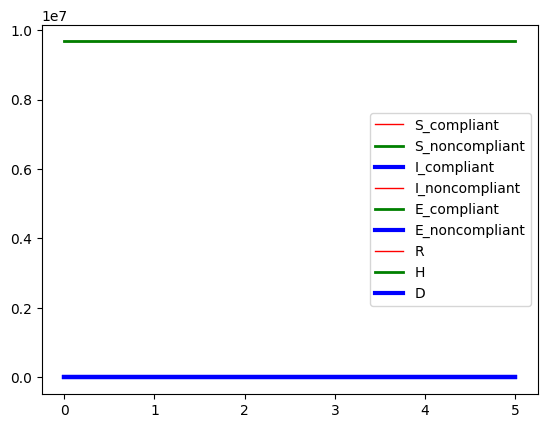

In [4]:
# i) (TA1 Search and Discovery Workflow, 1 Hr. Time Limit) Find estimates on the
# efficacy of surgical masks in preventing onward transmission of SARS-CoV-2 (preferred)
# or comparable viral respiratory pathogens (e.g., MERS-CoV, SARS), including any
# information about uncertainty in these estimates. The term surgical mask here refers to
# the commonly available, disposable procedure mask, not an N95-type respirator. Find 3
# credible documents that provide estimates and use your judgment to determine what
# value (in the deterministic case) or distribution (in the probabilistic case) to use in your
# forecasts in 1.a.iii.

# The base model assumes no masking inverventions, and we measure the efficacy in terms of the number of hospitalized.

funman_request = get_request()
setup_common(funman_request, debug=False, dreal_precision=1e-0)
add_unit_test(funman_request)
results = run(funman_request, model=models['original_stratified'])
report(results, "original_stratified", states["original_stratified"])

2024-09-04 15:23:42,710 - funman.server.worker - INFO - FunmanWorker running...
2024-09-04 15:23:42,713 - funman.server.worker - INFO - Starting work on: d609bf39-37bf-4a71-88cb-707eb9a1237d
2024-09-04 15:23:42,714 - funman.representation.interval - WARNING - [19340000.00000, 19340000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-09-04 15:23:42,714 - funman.representation.interval - WARNING - [0.40000, 0.40000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-09-04 15:23:42,715 - funman.representation.interval - WARNING - [0.40000, 0.40000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-09-04 15:23:42,715 - funman.representation.interval - WARNING - [0.60000, 0.60000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, 

1 points
                              N  beta  c_m_0  eps_m_0  c_m_1  eps_m_1  c_m_2  \
original_stratified  19340000.0   0.4    0.5      0.5    0.5      0.5    0.5   
destratified_SEI     19340000.0   0.4    NaN      NaN    NaN      NaN    NaN   

                     eps_m_2  c_m_3  eps_m_3  ...  p_H_to_R  r_H_to_R  \
original_stratified      0.5    0.5      0.5  ...      0.88       0.1   
destratified_SEI         NaN    NaN      NaN  ...      0.88       0.1   

                     p_H_to_D  r_H_to_D  p_noncompliant_compliant  \
original_stratified      0.12       0.1                       0.1   
destratified_SEI         0.12       0.1                       NaN   

                     p_compliant_noncompliant  eps_m_lb  eps_m_ub  c_m_lb  \
original_stratified                       0.1       NaN       NaN     NaN   
destratified_SEI                          NaN       0.4       0.6     0.4   

                     c_m_ub  
original_stratified     NaN  
destratified_SEI        0.6  


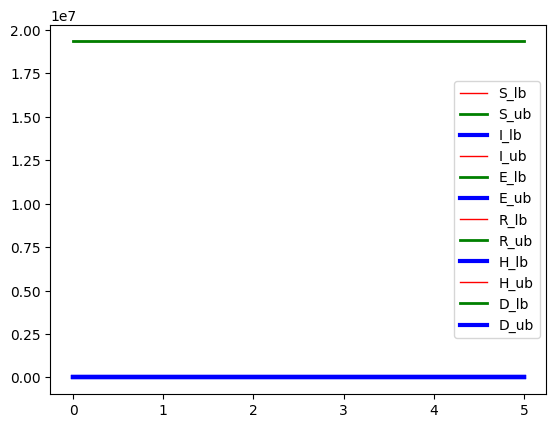

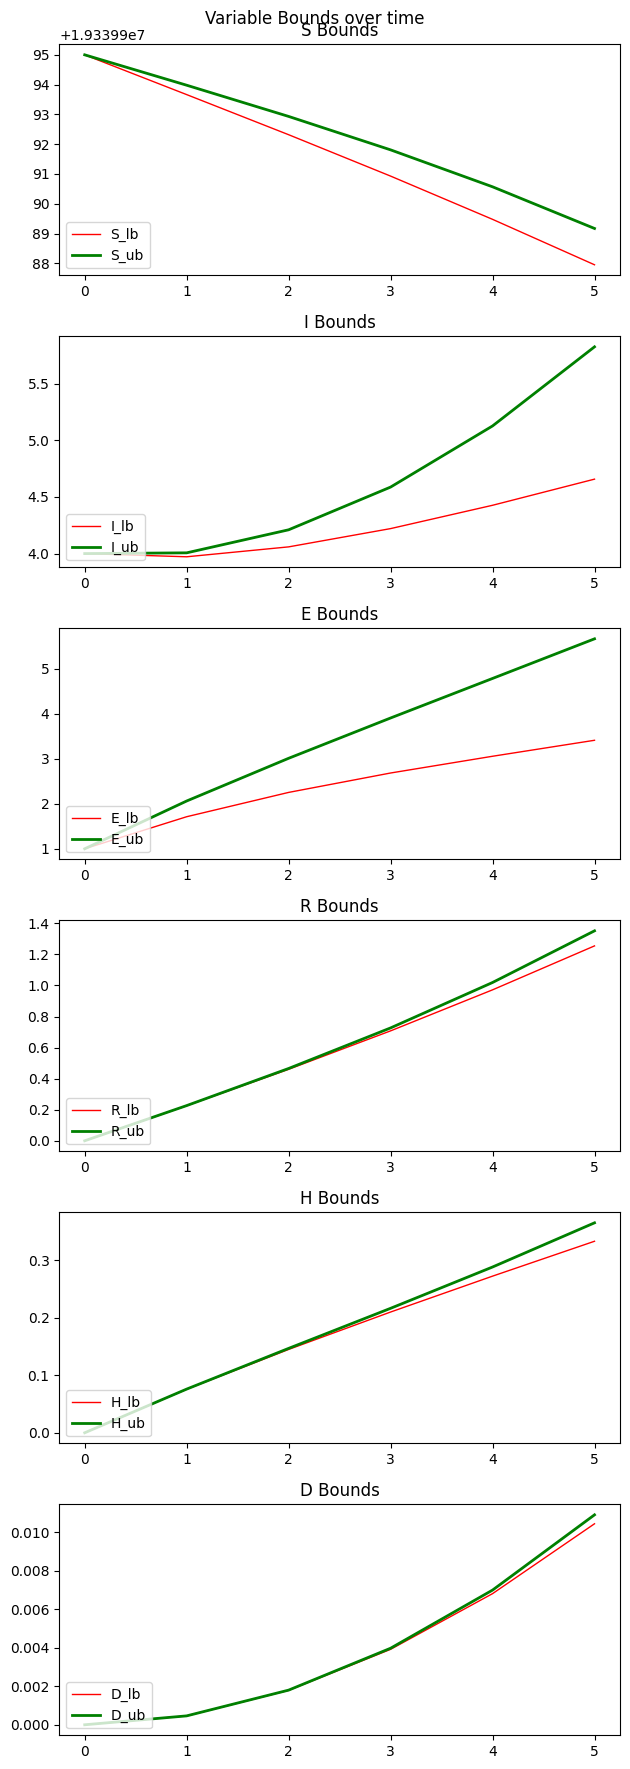

In [5]:
# Remove all stratification

funman_request = get_request()
setup_common(funman_request, debug=True, dreal_precision=1e-0)
# add_unit_test(funman_request, model=MODEL_DESTRATIFIED_ALL_PATH)
results = run(funman_request, model=models['destratified_SEI'])
report(results, "destratified_SEI", states=states['destratified_SEI'])
# plot_bounds(results.points()[0], vars=["S", "E", "I", "R", "H", "D"])
vars = results.model._state_var_names()
point = results.points()[0]
fig, axs = plot_bounds(point, vars=vars, basevar_map=basevar_map)

2024-09-04 15:23:55,838 - funman.server.worker - INFO - FunmanWorker running...
2024-09-04 15:23:55,842 - funman.server.worker - INFO - Starting work on: 54faa50d-80a7-4b89-8ee0-20987c4818a0
2024-09-04 15:23:55,842 - funman.representation.interval - WARNING - [19340000.00000, 19340000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-09-04 15:23:55,843 - funman.representation.interval - WARNING - [0.40000, 0.40000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-09-04 15:23:55,843 - funman.representation.interval - WARNING - [0.40000, 0.40000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-09-04 15:23:55,844 - funman.representation.interval - WARNING - [0.60000, 0.60000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, 

1 points
                              N  beta  c_m_0  eps_m_0  c_m_1  eps_m_1  c_m_2  \
original_stratified  19340000.0   0.4    0.5      0.5    0.5      0.5    0.5   
destratified_SEI     19340000.0   0.4    NaN      NaN    NaN      NaN    NaN   
destratified_SE      19340000.0   0.4    NaN      NaN    NaN      NaN    NaN   

                     eps_m_2  c_m_3  eps_m_3  ...  p_H_to_R  r_H_to_R  \
original_stratified      0.5    0.5      0.5  ...      0.88       0.1   
destratified_SEI         NaN    NaN      NaN  ...      0.88       0.1   
destratified_SE          NaN    NaN      NaN  ...      0.88       0.1   

                     p_H_to_D  r_H_to_D  p_noncompliant_compliant  \
original_stratified      0.12       0.1                       0.1   
destratified_SEI         0.12       0.1                       NaN   
destratified_SE          0.12       0.1                       0.1   

                     p_compliant_noncompliant  eps_m_lb  eps_m_ub  c_m_lb  \
original_stratified    

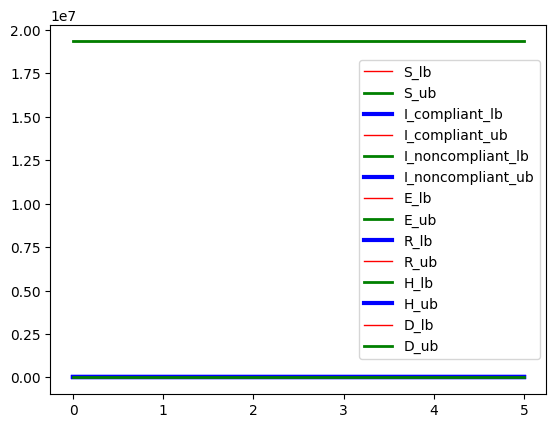

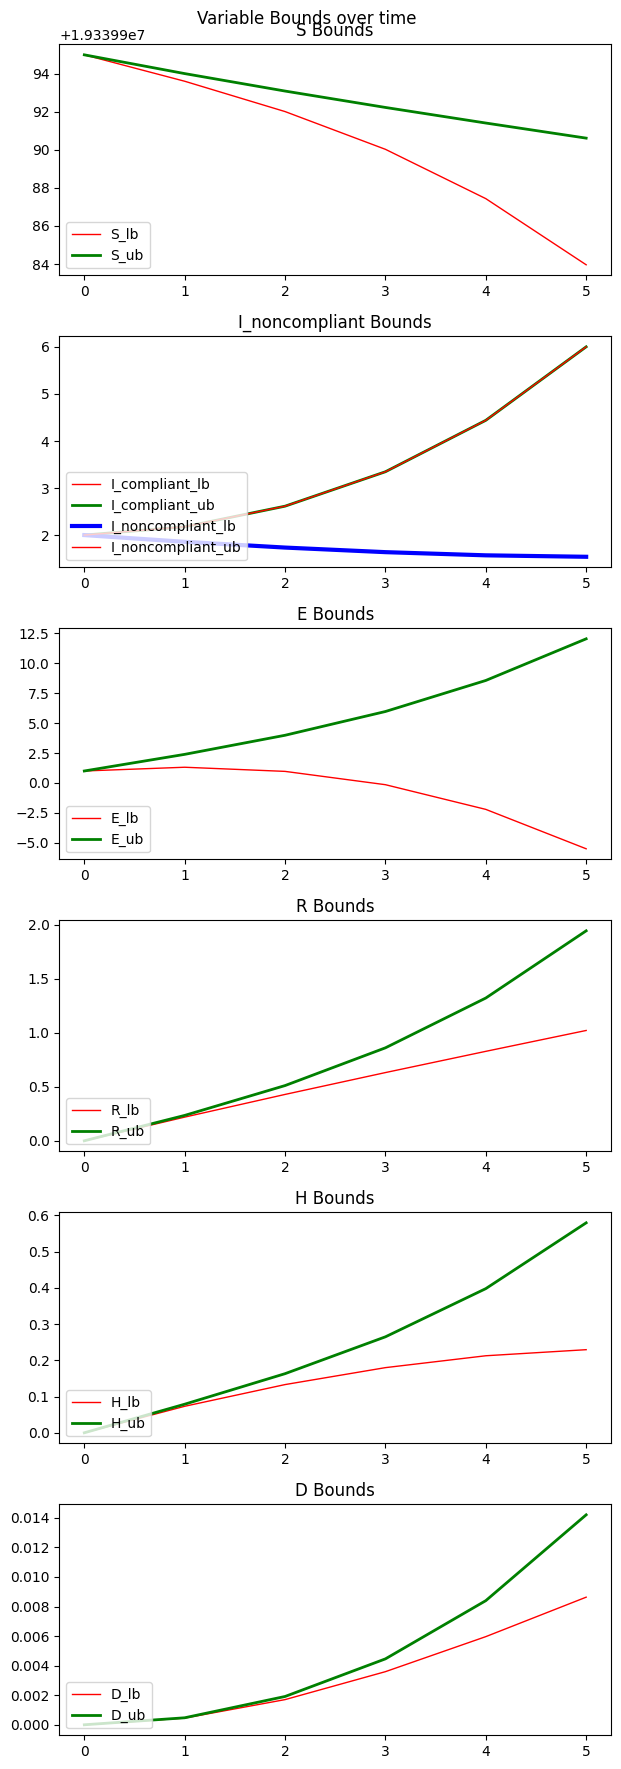

In [6]:
# Remove SE stratification

funman_request = get_request()
setup_common(funman_request, debug=True, dreal_precision=1e-0)
# add_unit_test(funman_request, model=MODEL_DESTRATIFIED_ALL_PATH)
results = run(funman_request, model=models['destratified_SE'])
report(results, "destratified_SE", states=states['destratified_SE'])
# plot_bounds(results.points()[0], vars=["S", "E", "I", "R", "H", "D"])
vars = results.model._state_var_names()
point = results.points()[0]
fig, axs = plot_bounds(point, vars=vars, basevar_map=basevar_map)

In [7]:

var = "E"
var_df = pd.DataFrame()
for name, result in request_results.items():
    # vars = list(set([v.rsplit("_", 1)[0] for v in result.model._state_var_names()]))
    vars = result.model._state_var_names()
    point = result.points()[0]
    tdf = result.points()[0].simulation.dataframe().T

    var_cols = tdf.columns.map(lambda x: x.startswith(var))
    # tdf.loc[var_cols.T]
    var_data = tdf.T.loc[var_cols].T
    var_data.columns = [f"{col}_{name}" for col in var_data.columns]
    print()
    var_df = pd.concat([var_df, var_data], axis=1)


og = var_df[f"{var}_compliant_original_stratified"] + var_df[f"{var}_noncompliant_original_stratified"] if f"{var}_compliant_original_stratified" in var_df.columns else None
ub_SE = var_df[f"{var}_noncompliant_ub_destratified_SE"] + var_df[f"{var}_compliant_ub_destratified_SE"] if f"{var}_noncompliant_ub_destratified_SE" in var_df.columns else None
lb_SE = var_df[f"{var}_noncompliant_lb_destratified_SE"] + var_df[f"{var}_compliant_lb_destratified_SE"] if f"{var}_noncompliant_lb_destratified_SE" in var_df.columns else None
ub_SEI = var_df[f"{var}_ub_destratified_SEI"] if f"{var}_ub_destratified_SEI" in var_df.columns else None
lb_SEI = var_df[f"{var}_lb_destratified_SEI"] if f"{var}_lb_destratified_SEI" in var_df.columns else None
[[og], [lb_SE, ub_SE], [lb_SEI, ub_SEI]]

[[0.0    1.000000
  1.0    1.900946
  2.0    2.659294
  3.0    3.339236
  4.0    3.986401
  5.0    4.634126
  dtype: float64],
 [None, None],
 [0.0    1.000000
  1.0    1.711692
  2.0    2.251305
  3.0    2.682140
  4.0    3.053780
  5.0    3.408531
  Name: E_lb_destratified_SEI, dtype: float64,
  0.0    1.000000
  1.0    2.060627
  2.0    3.008676
  3.0    3.903399
  4.0    4.781040
  5.0    5.660551
  Name: E_ub_destratified_SEI, dtype: float64]]

      S_compliant  I_compliant  E_compliant  I_noncompliant  S_noncompliant  \
0.0  9.669998e+06     2.000000     0.500000        2.000000    9.669998e+06   
1.0  9.669997e+06     1.995317     0.950473        1.995317    9.669997e+06   
2.0  9.669996e+06     2.070171     1.329647        2.070171    9.669996e+06   
3.0  9.669996e+06     2.208319     1.669618        2.208319    9.669996e+06   
4.0  9.669995e+06     2.399924     1.993201        2.399924    9.669995e+06   
5.0  9.669994e+06     2.639622     2.317063        2.639622    9.669994e+06   

     E_noncompliant         R         H         D  
0.0        0.500000  0.000000  0.000000  0.000000  
1.0        0.950473  0.226285  0.075753  0.000462  
2.0        1.329647  0.463073  0.145723  0.001795  
3.0        1.669618  0.717932  0.213148  0.003950  
4.0        1.993201  0.997238  0.280472  0.006910  
5.0        2.317063  1.306723  0.349626  0.010688  
             S_lb      I_lb      E_lb      I_ub          S_ub      E_ub  \
0.0  1.

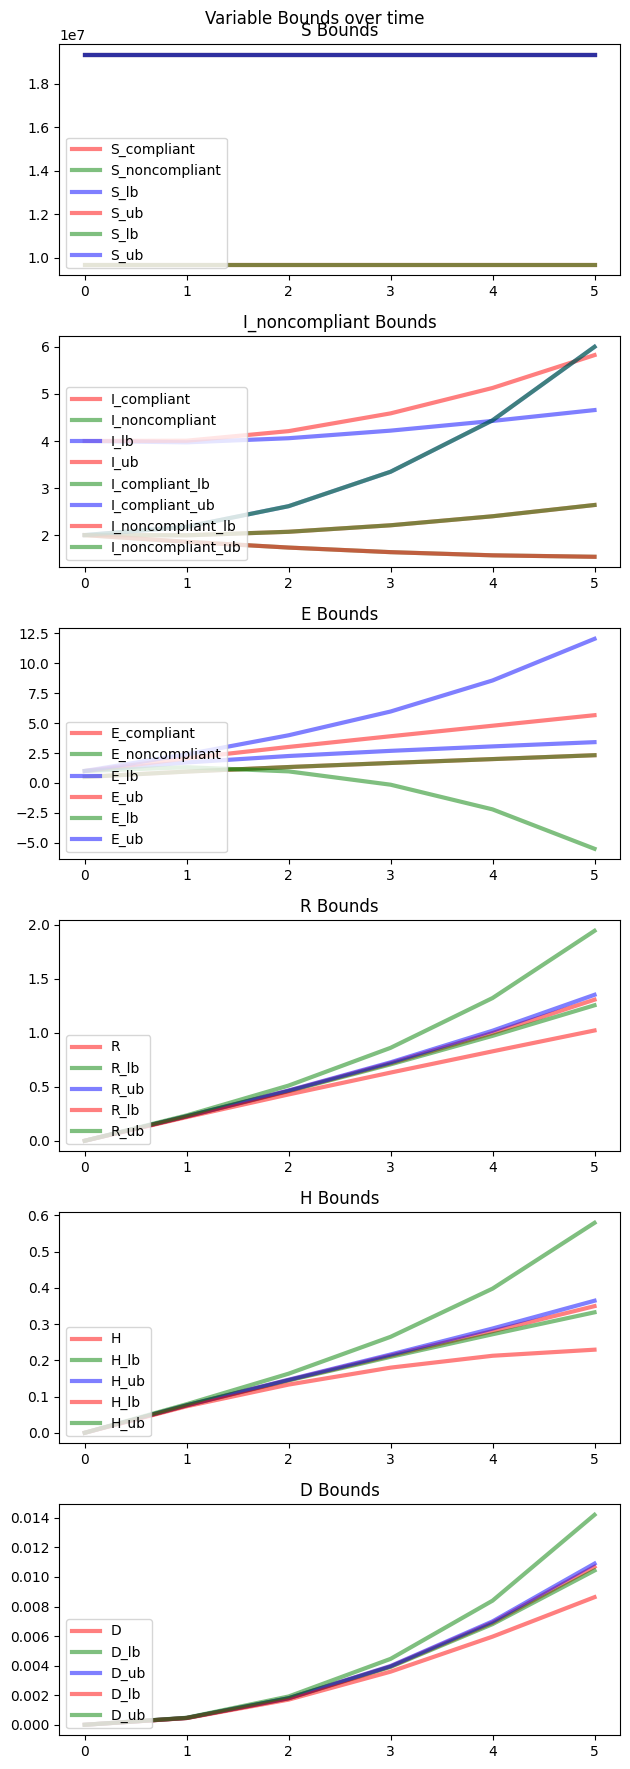

In [8]:


# point = results.points()[0]
# plot_bounds(point)
# points = {k:v.points()[0] for k,v in request_results.items()}
fig = None
axs = None


for name, result in request_results.items():
    # vars = list(set([v.rsplit("_", 1)[0] for v in result.model._state_var_names()]))
    vars = result.model._state_var_names()
    point = result.points()[0]
    # print(name)
    # print(vars)
    # print(point.simulation.dataframe())
    
    fig, axs = plot_bounds(point, vars=vars, fig=fig, axs=axs, basevar_map=basevar_map, alpha=0.5, linewidth=3)
    
# request_results